In [1]:
# !uv pip install -U astropy coniferest matplotlib torch

In [2]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from astropy.visualization import (AsinhStretch, PercentileInterval, ImageNormalize)
from coniferest.aadforest import AADForest
from coniferest.isoforest import IsolationForest
from coniferest.pineforest import PineForest
from coniferest.session import Session
from coniferest.session.callback import (
    TerminateAfter, prompt_decision_callback,
)

In [3]:
VECTORS_ROOT = Path(
    "/astro/store/epyc2/data/aritrag/comcam_dp1/hyrax_comcamp_dp1_runs_from_klone/results/20250716-165453-infer-qHSh/",
)
CUTOUT_ROOT = Path(
    "/astro/store/epyc2/data/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec",
)
for p in VECTORS_ROOT.iterdir():
    print(p)

/astro/store/epyc2/data/aritrag/comcam_dp1/hyrax_comcamp_dp1_runs_from_klone/results/20250716-165453-infer-qHSh/batch_0.npy
/astro/store/epyc2/data/aritrag/comcam_dp1/hyrax_comcamp_dp1_runs_from_klone/results/20250716-165453-infer-qHSh/batch_1.npy
/astro/store/epyc2/data/aritrag/comcam_dp1/hyrax_comcamp_dp1_runs_from_klone/results/20250716-165453-infer-qHSh/batch_10.npy
/astro/store/epyc2/data/aritrag/comcam_dp1/hyrax_comcamp_dp1_runs_from_klone/results/20250716-165453-infer-qHSh/batch_11.npy
/astro/store/epyc2/data/aritrag/comcam_dp1/hyrax_comcamp_dp1_runs_from_klone/results/20250716-165453-infer-qHSh/batch_12.npy
/astro/store/epyc2/data/aritrag/comcam_dp1/hyrax_comcamp_dp1_runs_from_klone/results/20250716-165453-infer-qHSh/batch_13.npy
/astro/store/epyc2/data/aritrag/comcam_dp1/hyrax_comcamp_dp1_runs_from_klone/results/20250716-165453-infer-qHSh/batch_2.npy
/astro/store/epyc2/data/aritrag/comcam_dp1/hyrax_comcamp_dp1_runs_from_klone/results/20250716-165453-infer-qHSh/batch_3.npy
/ast

In [4]:
data = np.concat([np.load(p) for p in VECTORS_ROOT.glob("batch_[0-9]*.npy")])
ids = data['id']
tensors = data['tensor']

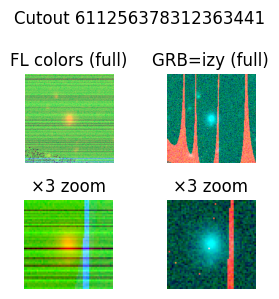

In [5]:
def normalize_rgb(rgb):
    normalized = []
    for channel in rgb:
        interval = PercentileInterval(99.5)
        norm = ImageNormalize(channel, interval=interval, stretch=AsinhStretch())
        norm_channel = norm(channel)
        normalized.append(np.clip(norm_channel, 0, 1))
    return np.array(normalized).transpose(1, 2, 0)


def make_rgb(cutout, scheme="FL"):
    if scheme == "FL":
        # First look extragalactic colors
        blue = 0.3 * cutout[0] + cutout[1]
        green = cutout[2]
        red = 0.05 * cutout[0] + cutout[3]
    elif scheme == "izy":
        red = cutout[5]
        green = cutout[4]
        blue = cutout[3]
    else:
        raise ValueError("Unknown scheme")

    rgb = np.array([red, green, blue])
    return normalize_rgb(rgb)


def zoom_cutout(cutout, zoom=3):
    nxny = np.array(cutout.shape[1:])
    cx, cy = nxny // 2
    new_nx, new_ny = nxny // zoom
    return cutout[:, cx - new_nx//2:cx + new_nx//2,
                     cy - new_ny//2:cy + new_ny//2]


def plot_cutout(id_, zoom=3, figsize=6):
    cutout = torch.load(CUTOUT_ROOT / f"cutout_{id_}.pt")
    cutout = np.nan_to_num(cutout, nan=0)

    fig, axes = plt.subplots(2, 2, figsize=(figsize, figsize))
    schemes = ["FL", "izy"]
    titles = ["FL colors", "GRB=izy"]

    for j, scheme in enumerate(schemes):
        # full
        rgb_full = make_rgb(cutout, scheme=scheme)
        axes[0, j].imshow(rgb_full, origin="lower")
        axes[0, j].set_title(f"{titles[j]} (full)")
        axes[0, j].axis("off")

        # zoomed
        zoomed = zoom_cutout(cutout, zoom=zoom)
        rgb_zoom = make_rgb(zoomed, scheme=scheme)
        axes[1, j].imshow(rgb_zoom, origin="lower")
        axes[1, j].set_title(f"×{zoom} zoom")
        axes[1, j].axis("off")

    fig.suptitle(f"Cutout {id_}")
    plt.tight_layout()
    plt.show()

plot_cutout(np.random.choice(ids))

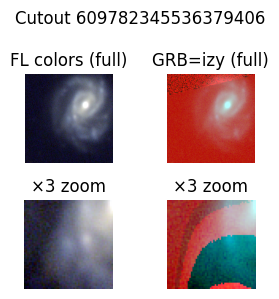

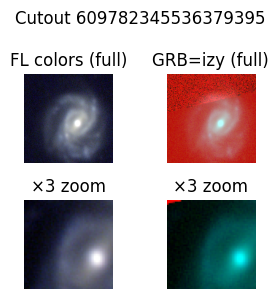

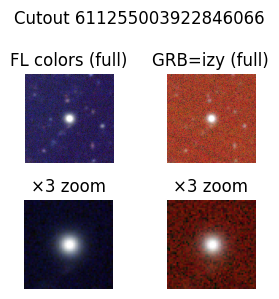

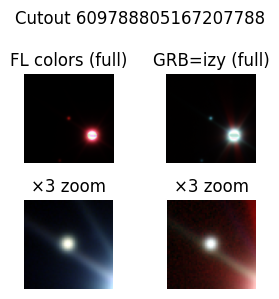

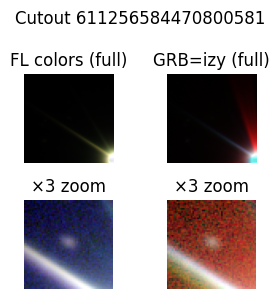

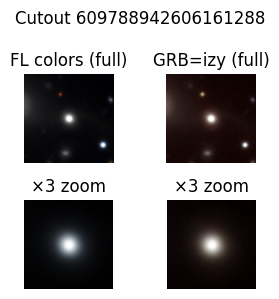

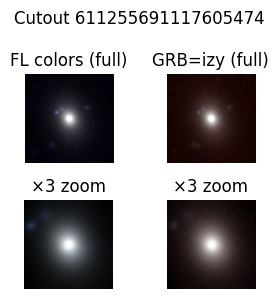

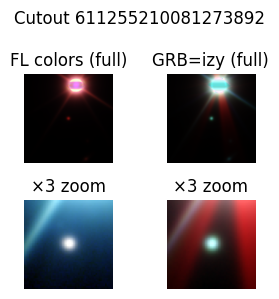

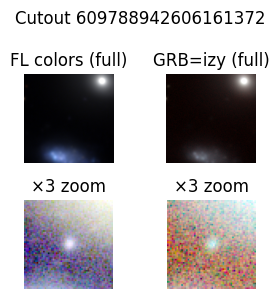

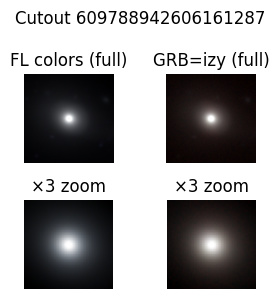

In [6]:
model = IsolationForest(random_seed=0)
model.fit(tensors)
scores = model.score_samples(tensors)

ids_by_score = ids[scores.argsort()]
for id_ in ids_by_score[:10]:
    plot_cutout(id_)

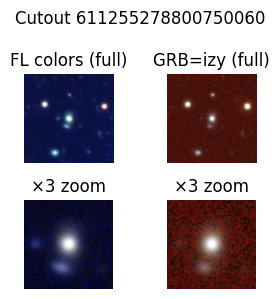

Is 611255278800750060 an anomaly? ([A]nomaly / yes, [R]egular / no, [U]nknown):

In [7]:
model = PineForest(
    # Number of trees to use for predictions
    n_trees=1024,
    # Number of new tree to grow for each decision
    n_spare_trees=3 * 1024,
    # Fix random seed for reproducibility
    random_seed=0,
    # n_subsamples=1024,
)

# model = AADForest(
#     n_trees=1024,
#     random_seed=0,
# )

def decision_callback(metadata, data, session):
    # Assuming metadata to be an ID
    plot_cutout(metadata, zoom=3)
    return prompt_decision_callback(metadata, data, session)

session = Session(
    data=tensors,
    metadata=ids,
    model=model,
    decision_callback=decision_callback,
    on_decision_callbacks=[
        # Terminate session after N decisions
        TerminateAfter(10),
    ],
)
session.run()